# NLS Normalization

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


# 0. Parameter Base


In [90]:
# 0. Parameter Base -----------------------------------------------------------
# Select one test ID, all plot/analysis params are loaded from TEST_CONFIGS.
TEST_CONFIGS = {
    'R2C3_UVA_2025_08_13': {
        'excel_path': 'Data_Base/2025-08-13_R2C3_UVA.hdf5.xlsx',
        'voltage_col': 'applied_E',
        'pulse_width_col': 'pulse_width',
        'delta_p_col': 'delta_P',
        'thickness_cm': 2.0e-6,
        'delta_p_unit': 'uC/cm^2',
        'delta_p_scale': 1.0,  # default delta_P input is already uC/cm^2
        'v_min': 0.5,
        'v_max': 4.0,
        'pw_min': None,
        'pw_max': 0.1,
        'power10_only': False,
        'plot': {
            'mode': 'delta_p_vs_pulse_width',  # options: delta_p_vs_pulse_width / delta_p_vs_efield
            'figsize': (10, 6),
            'legend_fontsize': 8,
        },
    },
    'SX19C_BOT_2024_12_03': {
        'excel_path': 'Data_Base/20241203_SX19C_bot_Heated_output.xlsx',
        'voltage_col': 'applied_E',
        'pulse_width_col': 'pulse_width',
        'delta_p_col': 'delta_P',
        'thickness_cm': 2.0e-6,
        'delta_p_unit': 'uC/cm^2',
        'delta_p_scale': 1.0,
        'v_min': 0.7,
        'v_max': 2.2,
        'pw_min': None,
        'pw_max': 1.0,
        'power10_only': False,
        'plot': {
            'mode': 'delta_p_vs_pulse_width',
            'figsize': (10, 6),
            'legend_fontsize': 8,
        },
    },
}

ACTIVE_TEST = 'SX19C_BOT_2024_12_03'

if ACTIVE_TEST not in TEST_CONFIGS:
    raise KeyError(f'ACTIVE_TEST={ACTIVE_TEST} not found. Available: {list(TEST_CONFIGS)}')

cfg = TEST_CONFIGS[ACTIVE_TEST]
plot_cfg = cfg.get('plot', {})

# Expose backward-compatible variables for downstream cells
excel_path = cfg['excel_path']
VOLTAGE_COL = cfg['voltage_col']
PULSE_WIDTH_COL = cfg['pulse_width_col']
DELTA_P_COL = cfg['delta_p_col']
THICKNESS_CM = float(cfg['thickness_cm'])
DELTA_P_UNIT = cfg['delta_p_unit']
DELTA_P_SCALE = float(cfg['delta_p_scale'])
V_MIN, V_MAX = float(cfg['v_min']), float(cfg['v_max'])
PW_MIN, PW_MAX = cfg.get('pw_min'), cfg.get('pw_max')
POWER10_ONLY = bool(cfg.get('power10_only', False))
PLOT_MODE = plot_cfg.get('mode', 'delta_p_vs_pulse_width')
PLOT_FIGSIZE = tuple(plot_cfg.get('figsize', (10, 6)))
PLOT_LEGEND_FONTSIZE = int(plot_cfg.get('legend_fontsize', 8))

# 1. Choose and Read

Active test: SX19C_BOT_2024_12_03
data shape: (17, 40)

column names: ['applied_E', 3e-08, 4e-08, 5e-08, 6.000000000000001e-08, 7e-08, 9.000000000000001e-08, 1e-07, 1.778e-07, 3.162e-07, 5.623e-07, 1e-06, 1.8e-06, 3.2e-06, 5.6e-06, 9.999999999999999e-06, 1.78e-05, 3.16e-05, 5.62e-05, 9.999999999999999e-05, 0.0001778, 0.0003162, 0.0005623, 0.001, 0.0018, 0.0032, 0.0056, 0.01, 0.0178, 0.0316, 0.05620000000000001, 0.1, 0.1778, 0.3162, 0.5622999999999999, 1, '1.1', 3, 5, 10]

data preview:

Voltage range filter: [0.7, 2.2] V -> 13/17 rows
Using THICKNESS_CM=2e-06 cm, delta_P unit=uC/cm^2


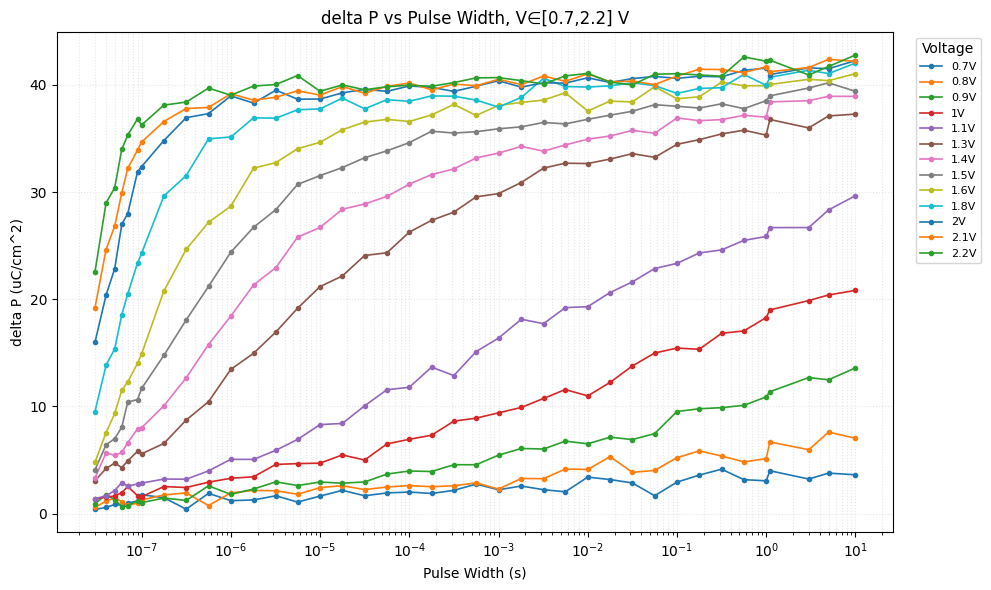

In [91]:
# 1. Data Load ----------------------------------------------------------------
df = pd.read_excel(excel_path, sheet_name=0)
df_Pr = pd.read_excel(excel_path, sheet_name=1)

print(f'Active test: {ACTIVE_TEST}')
print(f'data shape: {df.shape}')
print(f'\ncolumn names: {list(df.columns)}')
print('\ndata preview:')
df.head(10)


def parse_voltage_numeric(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s.astype(str).str.strip().str.replace('V', '', regex=False), errors='coerce')


def voltage_to_field(voltage: pd.Series | np.ndarray, thickness_cm: float) -> np.ndarray:
    if thickness_cm <= 0:
        raise ValueError('THICKNESS_CM must be > 0.')
    return np.asarray(voltage, dtype=float) / thickness_cm


def power10_pulse_cols(df_like: pd.DataFrame, voltage_col: str,
                       power10_only: bool = POWER10_ONLY, rtol: float = 1e-6) -> pd.DataFrame:
    cols = pd.Series([c for c in df_like.columns if c != voltage_col], name='col')
    pw_raw = pd.to_numeric(cols, errors='coerce')
    tab = pd.DataFrame({'col': cols, 'pulse_width_raw': pw_raw})
    tab = tab[np.isfinite(tab['pulse_width_raw']) & (tab['pulse_width_raw'] > 0)].copy()
    if tab.empty:
        raise ValueError('No numeric pulse-width columns found.')

    if power10_only:
        exp = np.round(np.log10(tab['pulse_width_raw'].to_numpy(dtype=float)))
        pw_pow10 = np.power(10.0, exp)
        keep = np.isclose(tab['pulse_width_raw'].to_numpy(dtype=float), pw_pow10, rtol=rtol, atol=0)
        tab = tab.loc[keep].copy()
        tab['pulse_width'] = pw_pow10[keep]
    else:
        tab = tab.copy()
        tab['pulse_width'] = tab['pulse_width_raw']

    tab['delta'] = np.abs(tab['pulse_width_raw'] - tab['pulse_width'])
    return tab.sort_values(['pulse_width', 'delta'])


def get_sorted_valid_arrays(df_dP: pd.DataFrame, df_Pr_like: pd.DataFrame, col: str, E_all: np.ndarray):
    dP_all = pd.to_numeric(df_dP[col], errors='coerce').to_numpy() * DELTA_P_SCALE
    Pr_all = pd.to_numeric(df_Pr_like[col], errors='coerce').to_numpy() * DELTA_P_SCALE if df_Pr_like is not None else None

    valid = np.isfinite(E_all) & np.isfinite(dP_all)
    if Pr_all is not None:
        valid &= np.isfinite(Pr_all)

    E = E_all[valid]
    dP_vals = -dP_all[valid]
    Pr_vals = Pr_all[valid] if Pr_all is not None else None

    if E.size < 2:
        return None, None, None

    order = np.argsort(E)
    E = E[order]
    dP_vals = dP_vals[order]
    if Pr_vals is not None:
        Pr_vals = Pr_vals[order]
    return E, dP_vals, Pr_vals


# 2. Range Filter -------------------------------------------------------------
V_num = parse_voltage_numeric(df[VOLTAGE_COL])
df_range = df.loc[V_num.between(V_MIN, V_MAX, inclusive='both')].reset_index(drop=True)

df_Pr_range = None
if df_Pr is not None:
    V_num_Pr = parse_voltage_numeric(df_Pr[VOLTAGE_COL])
    df_Pr_range = df_Pr.loc[V_num_Pr.between(V_MIN, V_MAX, inclusive='both')].reset_index(drop=True)

print(f'\nVoltage range filter: [{V_MIN}, {V_MAX}] V -> {len(df_range)}/{len(df)} rows')
print(f'Using THICKNESS_CM={THICKNESS_CM} cm, delta_P unit={DELTA_P_UNIT}')


# 3. Plot ---------------------------------------------------------------------
def plot_delta_p(df_plot: pd.DataFrame, mode: str = PLOT_MODE) -> None:
    col_pw_plot = power10_pulse_cols(df_plot, VOLTAGE_COL)

    if mode == 'delta_p_vs_efield':
        V_plot = parse_voltage_numeric(df_plot[VOLTAGE_COL]).to_numpy()
        E_plot = voltage_to_field(V_plot, THICKNESS_CM)

        fig, ax = plt.subplots(figsize=PLOT_FIGSIZE)
        for col in col_pw_plot['col']:
            y = pd.to_numeric(df_plot[col], errors='coerce').to_numpy() * DELTA_P_SCALE
            keep = np.isfinite(E_plot) & np.isfinite(y)
            if np.count_nonzero(keep) < 2:
                continue
            order = np.argsort(E_plot[keep])
            ax.plot(E_plot[keep][order], y[keep][order], marker='o', linewidth=1.2, markersize=3,
                    label=f'pw={float(col):g}s')

        ax.set_xlabel('E-field (V/cm) = V/thickness')
        ax.set_ylabel(f'delta P ({DELTA_P_UNIT})')
        ax.set_title(f'delta P vs E-field, V∈[{V_MIN},{V_MAX}] V')
        ax.grid(True, which='both', linestyle=':', alpha=0.3)
        ax.legend(title='pulse_width', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=PLOT_LEGEND_FONTSIZE)
        plt.tight_layout()
        plt.show()
        return

    if mode == 'delta_p_vs_pulse_width':
        V_plot = parse_voltage_numeric(df_plot[VOLTAGE_COL]).to_numpy()
        pw_vals = col_pw_plot['pulse_width'].to_numpy(dtype=float)
        pw_cols = list(col_pw_plot['col'])

        fig, ax = plt.subplots(figsize=PLOT_FIGSIZE)
        for i, v in enumerate(V_plot):
            if not np.isfinite(v):
                continue
            dP_row = np.array([pd.to_numeric(df_plot[c], errors='coerce').iloc[i] * DELTA_P_SCALE for c in pw_cols])
            keep = np.isfinite(dP_row)
            if np.count_nonzero(keep) < 2:
                continue
            ax.plot(pw_vals[keep], -dP_row[keep], marker='o', linewidth=1.2, markersize=3, label=f'{v:g}V')

        ax.set_xscale('log')
        ax.set_xlabel('Pulse Width (s)')
        ax.set_ylabel(f'delta P ({DELTA_P_UNIT})')
        ax.set_title(f'delta P vs Pulse Width, V∈[{V_MIN},{V_MAX}] V')
        ax.grid(True, which='both', linestyle=':', alpha=0.3)
        ax.legend(title='Voltage', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=PLOT_LEGEND_FONTSIZE)
        plt.tight_layout()
        plt.show()
        return

    raise ValueError(f'Unsupported plot mode: {mode}')


plot_delta_p(df_range, mode=PLOT_MODE)



#2. PLot delta P vs. width

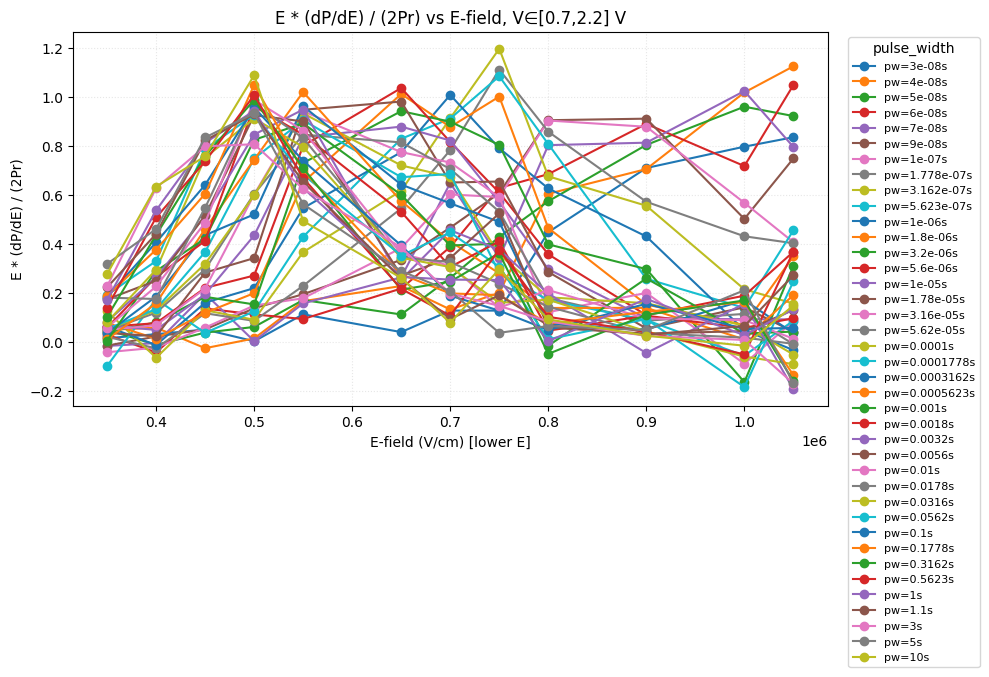

In [92]:
# calculate metric = E * (dP/dE) / (2Pr) for each 10^n pulse-width column

voltage_col = VOLTAGE_COL
df_use = df_range
df_Pr_use = df_Pr_range

if df_Pr_use is None:
    raise ValueError("Pr sheet is required.")

V_all = parse_voltage_numeric(df_use[voltage_col]).to_numpy()
E_all = voltage_to_field(V_all, THICKNESS_CM)
col_pw_df = power10_pulse_cols(df_use, voltage_col)
valid_cols = [c for c in col_pw_df['col'] if c in df_Pr_use.columns]

metric_rows = []
for col in valid_cols:
    pw_val = float(col_pw_df.loc[col_pw_df['col'] == col, 'pulse_width'].iloc[0])
    E, dP_vals, Pr = get_sorted_valid_arrays(df_use, df_Pr_use, col, E_all)
    if E is None:
        continue

    dE = np.diff(E)
    dP = np.diff(dP_vals)
    E_low = E[:-1]
    Pr_low = Pr[:-1]

    with np.errstate(divide='ignore', invalid='ignore'):
        metric = E_low * (dP / dE) / (2.0 * Pr_low)

    keep = np.isfinite(metric) & np.isfinite(E_low) & (dE != 0) & (Pr_low != 0)
    metric_rows.extend(
        {'pulse_width': pw_val, 'E_lower': float(e), 'metric': float(m)}
        for e, m in zip(E_low[keep], metric[keep])
    )

metric_df = pd.DataFrame(metric_rows)
if metric_df.empty:
    raise ValueError('metric_df is empty; check E parsing and valid data points.')

metric_df['E_lower_round'] = metric_df['E_lower'].round(6)
metric_df = metric_df.sort_values(['E_lower_round', 'pulse_width'])

fig, ax = plt.subplots(figsize=(10, 6))
for pw_val in sorted(metric_df['pulse_width'].unique()):
    sub = metric_df.loc[metric_df['pulse_width'] == pw_val].sort_values('E_lower')
    ax.plot(sub['E_lower'], sub['metric'], marker='o', linewidth=1.5, label=f"pw={pw_val:g}s")

ax.set_xlabel('E-field (V/cm) [lower E]')
ax.set_ylabel('E * (dP/dE) / (2Pr)')
ax.set_title(f'E * (dP/dE) / (2Pr) vs E-field, V∈[{V_MIN},{V_MAX}] V')
ax.grid(True, which='both', linestyle=':', alpha=0.3)
ax.legend(title='pulse_width', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()



# 3. Emax(t) + Normaliztion plot

pulse_width filter: [None, 1.0] -> 35 unique pulse widths


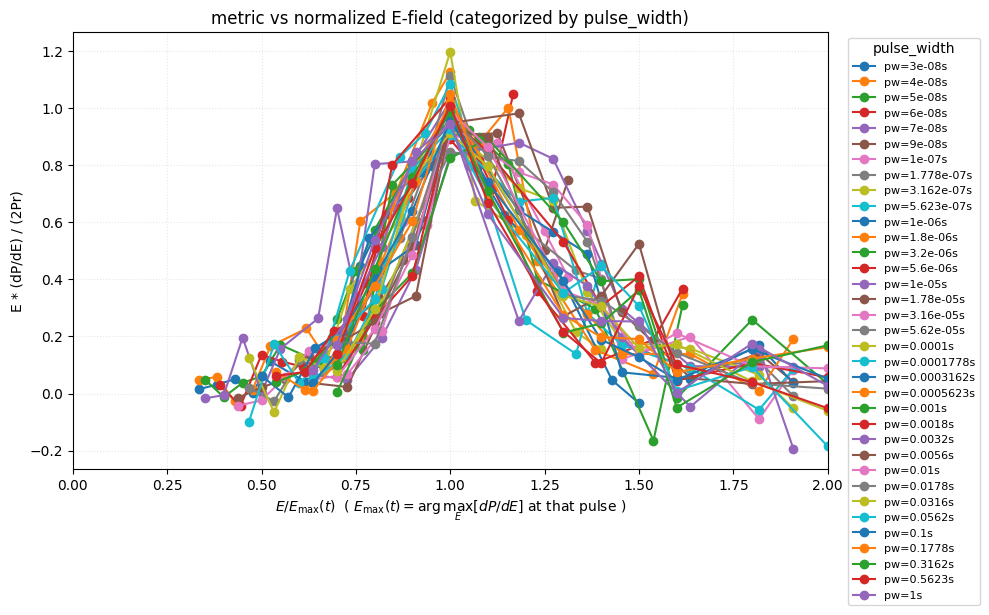

In [93]:
# calculate Emax(t)=argmax_E[dP/dE] for each pulse_width, then normalize x by E/Emax(t)

V_all_full = parse_voltage_numeric(df_use[voltage_col]).to_numpy()
E_all_full = voltage_to_field(V_all_full, THICKNESS_CM)
col_pw_df = power10_pulse_cols(df_use, voltage_col)

# apply pulse_width range filter
if PW_MIN is not None:
    col_pw_df = col_pw_df[col_pw_df['pulse_width'] >= PW_MIN]
if PW_MAX is not None:
    col_pw_df = col_pw_df[col_pw_df['pulse_width'] <= PW_MAX]
col_pw_df = col_pw_df.reset_index(drop=True)

pw_range_str = f"[{PW_MIN}, {PW_MAX}]" if (PW_MIN is not None or PW_MAX is not None) else "all"
print(f"pulse_width filter: {pw_range_str} -> {col_pw_df['pulse_width'].nunique()} unique pulse widths")

Emax_rows = []
for _, r in col_pw_df.drop_duplicates(subset=['pulse_width']).iterrows():
    col = r['col']
    pw_val = float(r['pulse_width'])
    if col not in df_Pr_use.columns:
        continue

    E, dP_vals, _ = get_sorted_valid_arrays(df_use, df_Pr_use, col, E_all_full)
    if E is None:
        continue

    dE = np.diff(E)
    E_low = E[:-1]
    with np.errstate(divide='ignore', invalid='ignore'):
        dP_dE = np.diff(dP_vals) / dE

    keep = np.isfinite(dP_dE) & np.isfinite(E_low) & (dE != 0)
    if not np.any(keep):
        continue

    Emax_t = float(E_low[keep][int(np.nanargmax(dP_dE[keep]))])
    Emax_rows.append({'pulse_width': pw_val, 'Emax_t': Emax_t})

Emax_df = pd.DataFrame(Emax_rows).drop_duplicates(subset=['pulse_width'])
if Emax_df.empty:
    raise ValueError('Failed to compute Emax(t).')

metric_df_pw = metric_df.copy()
if PW_MIN is not None:
    metric_df_pw = metric_df_pw[metric_df_pw['pulse_width'] >= PW_MIN]
if PW_MAX is not None:
    metric_df_pw = metric_df_pw[metric_df_pw['pulse_width'] <= PW_MAX]

metric_df_norm = metric_df_pw.merge(Emax_df, on='pulse_width', how='left')
metric_df_norm = metric_df_norm[np.isfinite(metric_df_norm['Emax_t']) & (metric_df_norm['Emax_t'] != 0)]
metric_df_norm['E_norm'] = metric_df_norm['E_lower'] / metric_df_norm['Emax_t']

fig, ax = plt.subplots(figsize=(10, 6))
for pw_val in sorted(metric_df_norm['pulse_width'].unique()):
    sub = metric_df_norm.loc[metric_df_norm['pulse_width'] == pw_val].sort_values('E_norm')
    ax.plot(sub['E_norm'], sub['metric'], marker='o', linewidth=1.5, label=f"pw={pw_val:g}s")

ax.set_xlabel(r'$E/E_{\max}(t)$  ( $E_{\max}(t)=\arg\max_E[dP/dE]$ at that pulse )')
ax.set_ylabel('E * (dP/dE) / (2Pr)')
ax.set_title('metric vs normalized E-field (categorized by pulse_width)')
ax.grid(True, which='both', linestyle=':', alpha=0.3)
ax.set_xlim(0, 2)
ax.legend(title='pulse_width', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()



# 4. Gaussian & Lorentzian fit

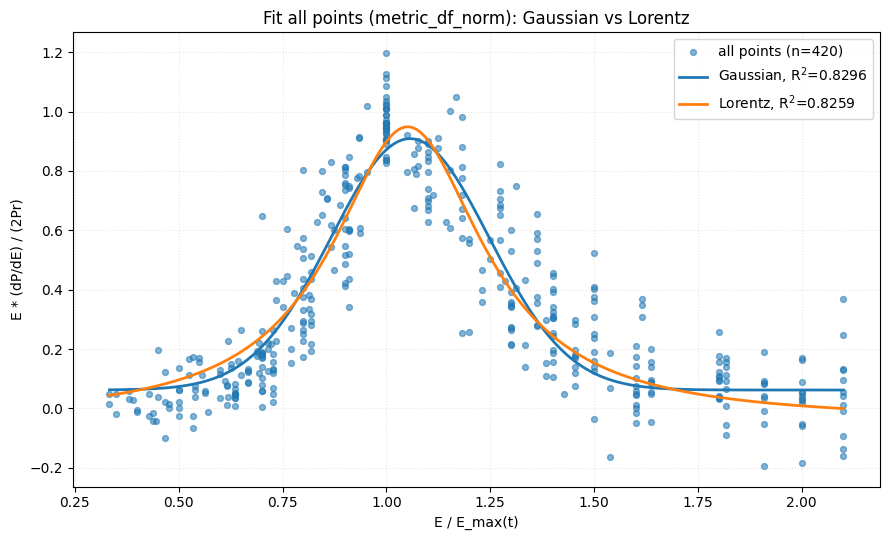

,model,A,x0,sigma,y0,R2,gamma
0,Gaussian,0.846774,1.057035,0.19037,0.062185,0.829568,NaN
1,Lorentz,0.991864,1.051323,NaN,-0.043124,0.825919,0.222978


In [ ]:
def gaussian(x, A, x0, sigma, y0):
    return y0 + A * np.exp(-0.5 * ((x - x0) / sigma) ** 2)

def lorentz(x, A, x0, gamma, y0):
    return y0 + A * (gamma**2) / ((x - x0) ** 2 + gamma**2)

x = metric_df_norm["E_norm"].to_numpy(dtype=float)
y = metric_df_norm["metric"].to_numpy(dtype=float)

# fit only necessary NaN/Inf filtering
m = np.isfinite(x) & np.isfinite(y)
x = x[m]
y = y[m]

# Initial guess
imax = int(np.argmax(y))
x0_guess = float(x[imax])
y0_guess = float(np.median(y))
A_guess = float(np.max(y) - y0_guess)
sigma_guess = 0.10
gamma_guess = 0.10

# Fit
popt_g, _ = curve_fit(gaussian, x, y, p0=[A_guess, x0_guess, sigma_guess, y0_guess], maxfev=20000)
popt_l, _ = curve_fit(lorentz,  x, y, p0=[A_guess, x0_guess, gamma_guess, y0_guess], maxfev=20000)

def r2(y_true, y_pred):
    ss_res = float(np.sum((y_true - y_pred) ** 2))
    ss_tot = float(np.sum((y_true - np.mean(y_true)) ** 2))
    return 1.0 - ss_res / ss_tot if ss_tot != 0 else np.nan

r2_g = r2(y, gaussian(x, *popt_g))
r2_l = r2(y, lorentz(x, *popt_l))

# Plot
x_grid = np.linspace(float(np.min(x)), float(np.max(x)), 500)

fig, ax = plt.subplots(figsize=(9, 5.5))
ax.scatter(x, y, s=18, alpha=0.55, label=f"all points (n={x.size})")
ax.plot(x_grid, gaussian(x_grid, *popt_g), linewidth=2.0, label=f"Gaussian, R$^2$={r2_g:.4f}")
ax.plot(x_grid, lorentz(x_grid, *popt_l),  linewidth=2.0, label=f"Lorentz, R$^2$={r2_l:.4f}")

ax.set_xlabel("E / E_max(t)")
ax.set_ylabel("E * (dP/dE) / (2Pr)")
ax.set_title("Fit all points (metric_df_norm): Gaussian vs Lorentz")
ax.grid(True, linestyle=":", alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

pd.DataFrame(
    [
        {"model": "Gaussian", "A": popt_g[0], "x0": popt_g[1], "sigma": popt_g[2], "y0": popt_g[3], "R2": r2_g},
        {"model": "Lorentz",  "A": popt_l[0], "x0": popt_l[1], "gamma": popt_l[2], "y0": popt_l[3], "R2": r2_l},
    ]
)

